# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [59]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import glob

In [60]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [61]:
# Define the directories that contain the files downloaded
dir_cs = "./1805_download/*.csv"

# Define the output path for the pickle
pickle_file = "clean_data.pickle" # path to save cleaned data


In [62]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id","loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", 
              "delinq_2yrs", "open_acc", "pub_rec", "fico_range_high","last_fico_range_low",  "last_fico_range_high", "fico_range_low", "revol_bal",
             "total_pymnt", "recoveries", "funded_amnt_inv","zip_code","last_pymnt_amnt",
               "term", "grade", "emp_length", "sub_grade","emp_title","title","addr_state","home_ownership", "application_type", "loan_status", "purpose", "verification_status"
               , 'int_rate', 'revol_util', 'issue_d', 'earliest_cr_line', 'last_pymnt_d'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", 
              "delinq_2yrs", "open_acc", "pub_rec", "fico_range_high","last_fico_range_low",  "last_fico_range_high", "fico_range_low", "revol_bal",
             "total_pymnt", "recoveries", "funded_amnt_inv","last_pymnt_amnt"]
cat_cols = ["term", "grade", "emp_length", "zip_code","sub_grade","emp_title","title","addr_state","home_ownership", "application_type", "loan_status", "purpose", "verification_status"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [63]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [64]:
#This function will ingest every file in the specified directory
#into a pandas dataframe. It will return a dictionary containing
#these dataframes, keyed by the file name.
    
#We assume the directory contains files directly downloaded from
#the link given in the handout, and *only* those files. Thus, we 
#assume the files are zipped (pd.read_csv can read zipped files) 
#and we assume the first line in each file needs to be skipped.
    
#Note that each file will be read *without* formatting
   
def ingest_files(directory):
    
    # If the directory has no trailing slash, add one
    #if directory[-1] != "/":
     #   directory = directory + "/"
    
    all_files = glob.glob(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(i, dtype = "str", skiprows= 1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        # mask rows that have non-integer IDs. Use is_integer method
        invalid_rows = ["0" if is_integer(row) else "1" for row in output[i]["id"]] 
        if invalid_rows.count("1") > 0:
            print("Found " + str(invalid_rows.count("1")) + " invalid rows which were removed")
            output[i] = output[i][output[i]["id"] != 1] # remove invalid rows
    
    return output # return dictionary of dataframe

In [65]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory ./1805_download/*.csv has 12 files:
    Reading file ./1805_download/LoanStats3b_securev1.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats3c_securev1.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats3d_securev1.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2017Q1.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2017Q2.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2017Q3.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2017Q4.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2016Q2.csv
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats3a_securev1.csv
Found 3 invalid rows which were removed
    Reading file ./1805_download/LoanStats_secu

### Combine the files

In [66]:
df1 = files_cs["./1805_download/LoanStats3a_securev1.csv"]
df2 = files_cs["./1805_download/LoanStats3b_securev1.csv"]
df3 = files_cs["./1805_download/LoanStats3c_securev1.csv"]
df4 = files_cs['./1805_download/LoanStats3d_securev1.csv']
#df5 = files_cs["./1805_download/LoanStats_securev1_2016Q1 2.csv"]
df6 = files_cs["./1805_download/LoanStats_securev1_2016Q1.csv"]
df7 = files_cs["./1805_download/LoanStats_securev1_2016Q2.csv"]
df8 = files_cs["./1805_download/LoanStats_securev1_2016Q3.csv"]
df9 = files_cs["./1805_download/LoanStats_securev1_2016Q4.csv"]
df10 = files_cs['./1805_download/LoanStats_securev1_2017Q1.csv']
df11 = files_cs['./1805_download/LoanStats_securev1_2017Q2.csv']
df12 = files_cs['./1805_download/LoanStats_securev1_2017Q3.csv']
#df13 = files_cs['./1805_download/LoanStats_securev1_2017Q4.csv']

In [67]:
new_df = df1.append(df2).append(df3).append(df4).append(df6).append(df7).append(df8).append(df9).append(df10).append(df11).append(df12)

In [68]:
new_df = new_df.reset_index(drop=True)

In [69]:
set(new_df.issue_d)

{'Apr-2008',
 'Apr-2009',
 'Apr-2010',
 'Apr-2011',
 'Apr-2012',
 'Apr-2013',
 'Apr-2014',
 'Apr-2015',
 'Apr-2016',
 'Apr-2017',
 'Aug-2007',
 'Aug-2008',
 'Aug-2009',
 'Aug-2010',
 'Aug-2011',
 'Aug-2012',
 'Aug-2013',
 'Aug-2014',
 'Aug-2015',
 'Aug-2016',
 'Aug-2017',
 'Dec-2007',
 'Dec-2008',
 'Dec-2009',
 'Dec-2010',
 'Dec-2011',
 'Dec-2012',
 'Dec-2013',
 'Dec-2014',
 'Dec-2015',
 'Dec-2016',
 'Feb-2008',
 'Feb-2009',
 'Feb-2010',
 'Feb-2011',
 'Feb-2012',
 'Feb-2013',
 'Feb-2014',
 'Feb-2015',
 'Feb-2016',
 'Feb-2017',
 'Jan-2008',
 'Jan-2009',
 'Jan-2010',
 'Jan-2011',
 'Jan-2012',
 'Jan-2013',
 'Jan-2014',
 'Jan-2015',
 'Jan-2016',
 'Jan-2017',
 'Jul-2007',
 'Jul-2008',
 'Jul-2009',
 'Jul-2010',
 'Jul-2011',
 'Jul-2012',
 'Jul-2013',
 'Jul-2014',
 'Jul-2015',
 'Jul-2016',
 'Jul-2017',
 'Jun-2007',
 'Jun-2008',
 'Jun-2009',
 'Jun-2010',
 'Jun-2011',
 'Jun-2012',
 'Jun-2013',
 'Jun-2014',
 'Jun-2015',
 'Jun-2016',
 'Jun-2017',
 'Mar-2008',
 'Mar-2009',
 'Mar-2010',
 'Mar-2011',

In [58]:
new_df[["id", "loan_amnt", "funded_amnt", "total_pymnt"]]

,id,loan_amnt,funded_amnt,total_pymnt
0,1077501,5000,5000,5863.1551866952
1,1077430,2500,2500,1014.53
2,1077175,2400,2400,3005.6668441393
3,1076863,10000,10000,12231.890000000902
4,1075358,3000,3000,4066.9081610817
5,1075269,5000,5000,5632.209999999401
6,1069639,7000,7000,10137.840007529006
7,1072053,3000,3000,3939.135293905698
8,1071795,5600,5600,647.5
9,1071570,5375,5375,1484.59


## Prepare Final Dataset

In [70]:
# Keep only the columns of interest from 'data_cs'
final_data = new_df[cols_to_pick]

In [13]:
final_data[["id", "loan_amnt", "funded_amnt", "total_pymnt"]]

,id,loan_amnt,funded_amnt,total_pymnt
0,1077501,5000,5000,5863.1551866952
1,1077430,2500,2500,1014.53
2,1077175,2400,2400,3005.6668441393
3,1076863,10000,10000,12231.890000000902
4,1075358,3000,3000,4066.9081610817
5,1075269,5000,5000,5632.209999999401
6,1069639,7000,7000,10137.840007529006
7,1072053,3000,3000,3939.135293905698
8,1071795,5600,5600,647.5
9,1071570,5375,5375,1484.59


In [71]:
print("Starting with " + str(len(final_data)) + " rows and " + str(len(final_data.columns)) + " columns")

Starting with 1646801 rows and 36 columns


### Typecast the columns

In [72]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = pd.to_numeric(final_data[i], downcast="float") # typecast float columns

/Users/emmanuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [73]:
set(final_data.issue_d)

{'Apr-2008',
 'Apr-2009',
 'Apr-2010',
 'Apr-2011',
 'Apr-2012',
 'Apr-2013',
 'Apr-2014',
 'Apr-2015',
 'Apr-2016',
 'Apr-2017',
 'Aug-2007',
 'Aug-2008',
 'Aug-2009',
 'Aug-2010',
 'Aug-2011',
 'Aug-2012',
 'Aug-2013',
 'Aug-2014',
 'Aug-2015',
 'Aug-2016',
 'Aug-2017',
 'Dec-2007',
 'Dec-2008',
 'Dec-2009',
 'Dec-2010',
 'Dec-2011',
 'Dec-2012',
 'Dec-2013',
 'Dec-2014',
 'Dec-2015',
 'Dec-2016',
 'Feb-2008',
 'Feb-2009',
 'Feb-2010',
 'Feb-2011',
 'Feb-2012',
 'Feb-2013',
 'Feb-2014',
 'Feb-2015',
 'Feb-2016',
 'Feb-2017',
 'Jan-2008',
 'Jan-2009',
 'Jan-2010',
 'Jan-2011',
 'Jan-2012',
 'Jan-2013',
 'Jan-2014',
 'Jan-2015',
 'Jan-2016',
 'Jan-2017',
 'Jul-2007',
 'Jul-2008',
 'Jul-2009',
 'Jul-2010',
 'Jul-2011',
 'Jul-2012',
 'Jul-2013',
 'Jul-2014',
 'Jul-2015',
 'Jul-2016',
 'Jul-2017',
 'Jun-2007',
 'Jun-2008',
 'Jun-2009',
 'Jun-2010',
 'Jun-2011',
 'Jun-2012',
 'Jun-2013',
 'Jun-2014',
 'Jun-2015',
 'Jun-2016',
 'Jun-2017',
 'Mar-2008',
 'Mar-2009',
 'Mar-2010',
 'Mar-2011',

In [74]:
final_data = final_data.dropna(subset=float_cols)

In [75]:
set(final_data.issue_d)

{'Apr-2008',
 'Apr-2009',
 'Apr-2010',
 'Apr-2011',
 'Apr-2012',
 'Apr-2013',
 'Apr-2014',
 'Apr-2015',
 'Apr-2016',
 'Apr-2017',
 'Aug-2007',
 'Aug-2008',
 'Aug-2009',
 'Aug-2010',
 'Aug-2011',
 'Aug-2012',
 'Aug-2013',
 'Aug-2014',
 'Aug-2015',
 'Aug-2016',
 'Aug-2017',
 'Dec-2007',
 'Dec-2008',
 'Dec-2009',
 'Dec-2010',
 'Dec-2011',
 'Dec-2012',
 'Dec-2013',
 'Dec-2014',
 'Dec-2015',
 'Dec-2016',
 'Feb-2008',
 'Feb-2009',
 'Feb-2010',
 'Feb-2011',
 'Feb-2012',
 'Feb-2013',
 'Feb-2014',
 'Feb-2015',
 'Feb-2016',
 'Feb-2017',
 'Jan-2008',
 'Jan-2009',
 'Jan-2010',
 'Jan-2011',
 'Jan-2012',
 'Jan-2013',
 'Jan-2014',
 'Jan-2015',
 'Jan-2016',
 'Jan-2017',
 'Jul-2007',
 'Jul-2008',
 'Jul-2009',
 'Jul-2010',
 'Jul-2011',
 'Jul-2012',
 'Jul-2013',
 'Jul-2014',
 'Jul-2015',
 'Jul-2016',
 'Jul-2017',
 'Jun-2007',
 'Jun-2008',
 'Jun-2009',
 'Jun-2010',
 'Jun-2011',
 'Jun-2012',
 'Jun-2013',
 'Jun-2014',
 'Jun-2015',
 'Jun-2016',
 'Jun-2017',
 'Mar-2008',
 'Mar-2009',
 'Mar-2010',
 'Mar-2011',

In [17]:
final_data[["id", "loan_amnt", "funded_amnt", "total_pymnt"]]

,id,loan_amnt,funded_amnt,total_pymnt
0,1077501,5000.0,5000.0,5863.155273
1,1077430,2500.0,2500.0,1014.530029
2,1077175,2400.0,2400.0,3005.666748
3,1076863,10000.0,10000.0,12231.889648
4,1075358,3000.0,3000.0,4066.908203
5,1075269,5000.0,5000.0,5632.209961
6,1069639,7000.0,7000.0,10137.839844
7,1072053,3000.0,3000.0,3939.135254
8,1071795,5600.0,5600.0,647.500000
9,1071570,5375.0,5375.0,1484.589966


In [76]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [77]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

In [78]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [79]:
for i in cat_cols:
    final_data[i].replace("null", None)
    final_data[i].replace("", None)

In [80]:
final_data = final_data.dropna(subset=float_cols)

In [81]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [22]:
set(final_data["total_pymnt"].values)

{0.0,
 0.75,
 0.8,
 12169.307,
 5.0,
 3750.19,
 17.58,
 20.0,
 25.0,
 30.96,
 33.97,
 34.41,
 35.9,
 35.79,
 35.0,
 35.34,
 38.8,
 40.79,
 33.85,
 41.11,
 41.49,
 43.48,
 45.0,
 46.37,
 49.84,
 51.02,
 51.4,
 17351.955,
 57.5,
 58.03,
 60.1,
 61.88,
 60.05,
 63.0,
 64.47,
 65.62,
 66.94,
 67.5,
 67.8,
 69.78,
 70.07,
 69.0,
 70.0,
 69.44,
 74.92,
 69.01,
 76.64,
 76.71,
 78.97,
 76.18,
 79.21,
 81.0,
 81.25,
 83.89,
 84.24,
 85.3,
 86.05,
 84.23,
 84.4,
 88.49,
 90.0,
 91.39,
 92.66,
 93.03,
 92.0,
 95.43,
 90.44,
 97.05,
 92.05,
 96.41,
 100.0,
 100.7,
 102.83,
 94.53,
 104.0,
 105.22,
 106.95,
 98.99,
 108.0,
 108.32,
 110.8,
 16673.87,
 112.5,
 113.74,
 16673.57,
 115.0,
 16673.09,
 16673.47,
 16673.35,
 119.08,
 119.27,
 121.29,
 121.81,
 121.69,
 121.47,
 121.25,
 126.06,
 127.83,
 127.02,
 129.13,
 130.05,
 126.35,
 126.78,
 128.18,
 132.24,
 135.76,
 135.0,
 136.01,
 135.85,
 139.08,
 140.14,
 141.34,
 142.0,
 143.75,
 144.62,
 136.92,
 146.52,
 146.12,
 148.86,
 145.02,
 147.31

## Calculate returns for each loan

In [82]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [83]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data["loan_length"]!= 0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 5579 rows


In [84]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

### M1-Pessimistic Method

In [85]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((pd.to_numeric(final_data["total_pymnt"]) - pd.to_numeric(final_data["funded_amnt"])) / pd.to_numeric(final_data["funded_amnt"]))*(12 / final_data['term_num'])



In [86]:
final_data[["id", "loan_amnt", "funded_amnt", "total_pymnt", "ret_PESS"]].head()

,id,loan_amnt,funded_amnt,total_pymnt,ret_PESS
0,1077501,5000.0,5000.0,5863.155273,0.057544
1,1077430,2500.0,2500.0,1014.530029,-0.118838
2,1077175,2400.0,2400.0,3005.666748,0.084120
3,1076863,10000.0,10000.0,12231.889648,0.074396
4,1075358,3000.0,3000.0,4066.908203,0.071127


### M2-Optimistic Method

In [87]:
final_data["days_lenght"] = final_data["last_pymnt_d"] - final_data["issue_d"]

In [88]:
final_data["actual_months_lenght"] = [x.total_seconds()/(60*60*24*30) for x in final_data["days_lenght"]]

In [89]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

diff = (pd.to_numeric(final_data["total_pymnt"]) - pd.to_numeric(final_data["funded_amnt"]))/pd.to_numeric(final_data["funded_amnt"])

final_data['ret_OPT'] = np.where((pd.to_numeric(final_data["total_pymnt"]) - pd.to_numeric(final_data["funded_amnt"])) <= 0 
, (diff)*(12 / pd.to_numeric(final_data['term_num']))
, (diff)*(12 / pd.to_numeric(final_data['actual_months_lenght'])))



# final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data["ret_PESS"]

In [90]:
final_data[["id", "loan_amnt", "funded_amnt", "total_pymnt", "ret_PESS", "ret_OPT"]].head()

,id,loan_amnt,funded_amnt,total_pymnt,ret_PESS,ret_OPT
0,1077501,5000.0,5000.0,5863.155273,0.057544,0.055144
1,1077430,2500.0,2500.0,1014.530029,-0.118838,-0.118838
2,1077175,2400.0,2400.0,3005.666748,0.084120,0.099507
3,1076863,10000.0,10000.0,12231.889648,0.074396,0.071294
4,1075358,3000.0,3000.0,4066.908203,0.071127,0.068907


In [91]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [92]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id","loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", 
              "delinq_2yrs", "open_acc", "pub_rec", "fico_range_high","last_fico_range_low",  "last_fico_range_high", "fico_range_low", "revol_bal",
             "total_pymnt", "recoveries", "funded_amnt_inv","zip_code","last_pymnt_amnt",
               "term", "grade", "emp_length", "sub_grade","emp_title","title","addr_state","home_ownership", "application_type", "loan_status", "purpose", "verification_status"
               , 'int_rate', 'revol_util', 'issue_d', 'earliest_cr_line', 'last_pymnt_d'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", 
              "delinq_2yrs", "open_acc", "pub_rec", "fico_range_high","last_fico_range_low",  "last_fico_range_high", "fico_range_low", "revol_bal",
             "total_pymnt", "recoveries", "funded_amnt_inv","last_pymnt_amnt"]
cat_cols = ["term", "grade", "emp_length", "zip_code","sub_grade","emp_title","title","addr_state","home_ownership", "application_type", "loan_status", "purpose", "verification_status"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [93]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

In [94]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

### Method 3

In [95]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / pd.to_numeric(final_data["loan_length"]) 

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    
    cash_by_end_of_loan = actual_installment *(((1 + i)**pd.to_numeric(final_data["loan_length"]))-1)/ (i) # compute the quantity given in [] in eq.2.3 of handout
                           
                           
                           #* 
                           #((1 + i)**(T-pd.to_numeric(final_data["actual_months_lenght"])) - pd.to_numeric(final_data["funded_amnt"]))) * (1/pd.to_numeric(final_data["funded_amnt"]))*(12/T)
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (1 + i )**remaining_months  - pd.to_numeric(final_data["funded_amnt"]))*1/pd.to_numeric(final_data["funded_amnt"])

    # Find the percentage return
    ret_val = (12/T) * final_return
    return ret_val


In [96]:
final_data['ret_INTa'] = ret_method_3(60, 0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60, 0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [97]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = np.sort(final_data[i])[0:3] # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [98]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print("number of unique values: "  +str(len(final_data[i].unique()))) # print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [99]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()
        

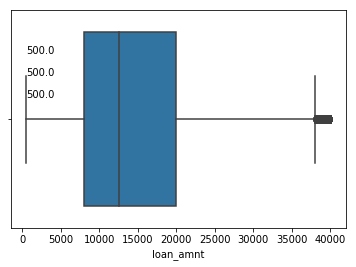

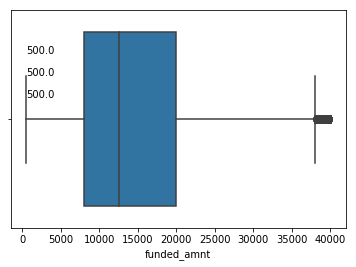

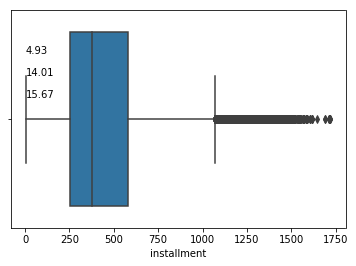

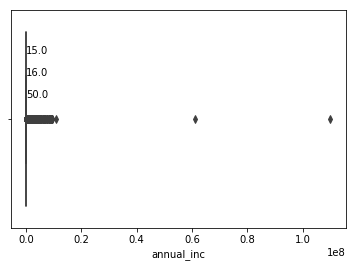

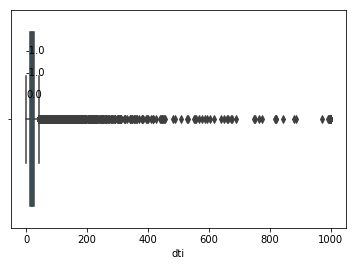

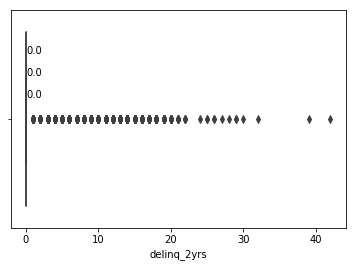

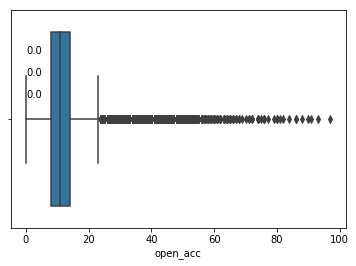

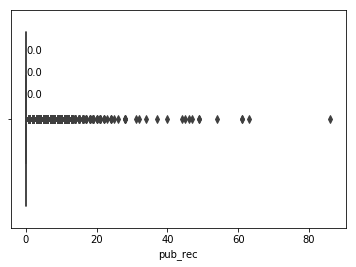

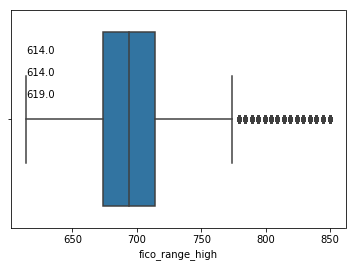

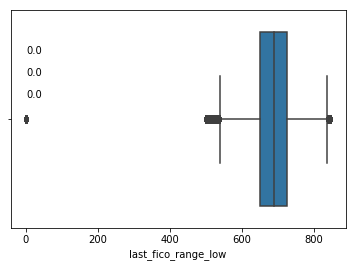

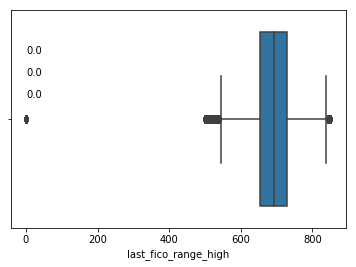

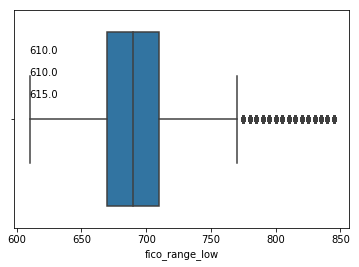

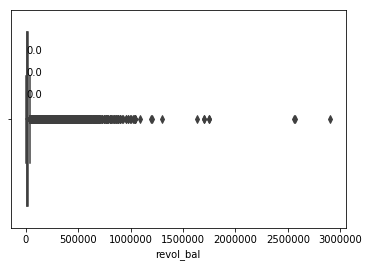

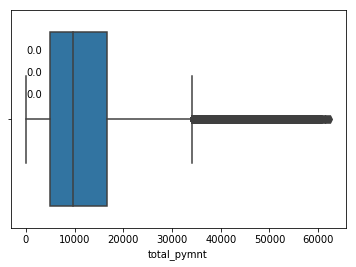

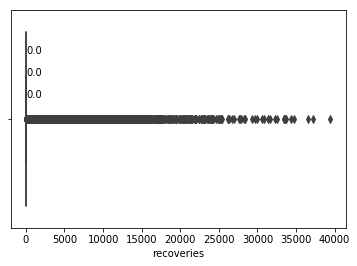

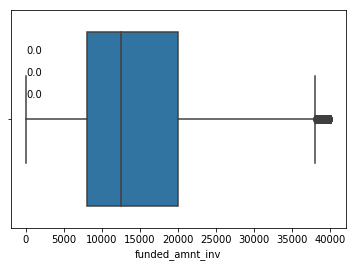

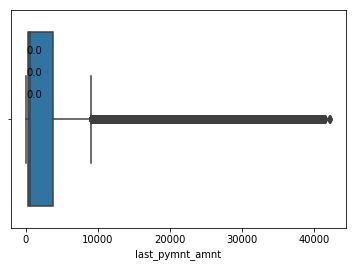

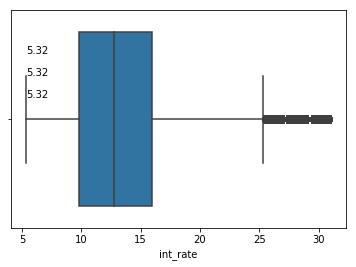

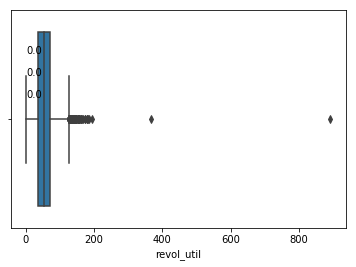

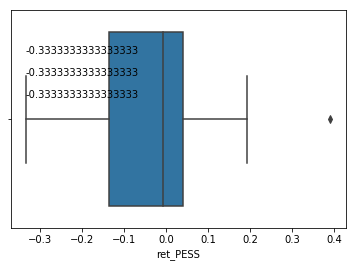

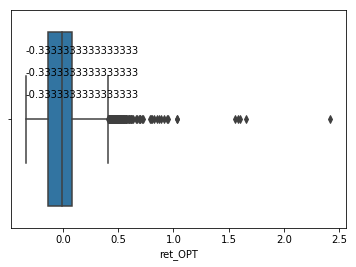

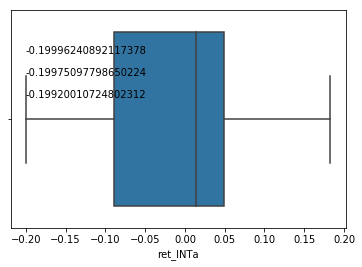

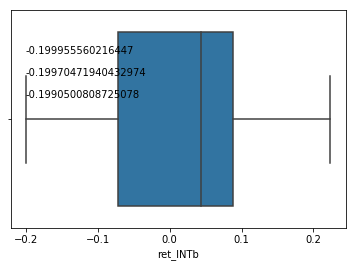

term
number of unique values: 2
 36 months    1178107
 60 months     462706
Name: term, dtype: int64


grade
number of unique values: 7
C    488889
B    483784
A    271940
D    236593
E    111482
F     37212
G     10913
Name: grade, dtype: int64


emp_length
number of unique values: 12
10+ years    547602
2 years      147878
< 1 year     132888
3 years      130406
1 year       107285
5 years      101491
4 years       97793
6 years       75358
8 years       72446
7 years       70165
9 years       62985
Name: emp_length, dtype: int64


zip_code
number of unique values: 952
945xx    17536
750xx    17339
112xx    17174
606xx    15633
300xx    14949
331xx    13676
070xx    13419
770xx    12929
100xx    12903
900xx    12465
891xx    12144
330xx    12045
117xx    11670
104xx    11576
917xx    11290
852xx    10266
921xx     9657
926xx     9446
925xx     9309
913xx     9213
334xx     9013
604xx     8804
601xx     8787
481xx     8645
113xx     8450
080xx     8433
600xx     8385
853xx     8306
95

number of unique values: 6
MORTGAGE    812376
RENT        651016
OWN         176686
ANY            503
OTHER          182
NONE            50
Name: home_ownership, dtype: int64


application_type
number of unique values: 2
Individual    1606762
Joint App       34051
Name: application_type, dtype: int64


loan_status
number of unique values: 9
Fully Paid                                             731118
Current                                                682208
Charged Off                                            191747
Late (31-120 days)                                      19278
In Grace Period                                          8022
Late (16-30 days)                                        5335
Does not meet the credit policy. Status:Fully Paid       1962
Does not meet the credit policy. Status:Charged Off       758
Default                                                   385
Name: loan_status, dtype: int64


purpose
number of unique values: 14
debt_consolidation    952808

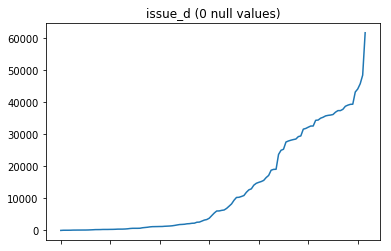

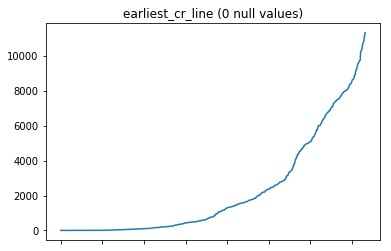

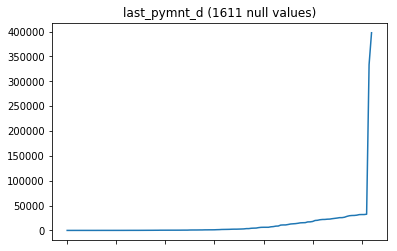

In [100]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [39]:
final_data["recoveries"].quantile(0.75) 

0.0

In [101]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [102]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

final_data = final_data[final_data["annual_inc"]< (final_data["annual_inc"].quantile(0.75) + 1.5*(final_data["annual_inc"].quantile(0.75) - final_data["annual_inc"].quantile(0.25)))] # remove outliers based 1st obvious feature
print("Removed " + str(n_rows - len(final_data)) + " rows")
n_rows = len(final_data)

final_data = final_data[final_data["dti"]< (final_data["dti"].quantile(0.75) + 1.5*(final_data["dti"].quantile(0.75) - final_data["dti"].quantile(0.25)))] # remove outliers based 1st obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

n_rows = len(final_data)

final_data = final_data[final_data["open_acc"]< (final_data["open_acc"].quantile(0.75) + 1.5*(final_data["open_acc"].quantile(0.75) - final_data["open_acc"].quantile(0.25)))] # remove outliers based 1st obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

n_rows = len(final_data)

final_data = final_data[final_data["revol_bal"]< (final_data["revol_bal"].quantile(0.75) + 1.5*(final_data["revol_bal"].quantile(0.75) - final_data["revol_bal"].quantile(0.25)))] # remove outliers based 1st obvious feature
print("Removed " + str(n_rows - len(final_data)) + " rows")
n_rows = len(final_data)



final_data = final_data[final_data["revol_util"]< (final_data["revol_util"].quantile(0.75) + 1.5*(final_data["revol_util"].quantile(0.75) - final_data["revol_util"].quantile(0.25)))] # remove outliers based 1st obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

n_rows = len(final_data)


#final_data = ... # remove outliers based 2nd obvious feature
#...
#final_data = ... # remove outliers based kth obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 76627 rows
Removed 6779 rows
Removed 66073 rows
Removed 81162 rows
Removed 887 rows
Removed 0 rows


In [103]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [104]:
# Remove all loans that are still current
n_rows = len(final_data)

filtering_status = [ x  in ["Fully Paid","Charged Off","Default"] for x in final_data["loan_status"]]

final_data = final_data[filtering_status]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 602323 rows


In [105]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d

In [43]:
# Only include loans isssued since 2010
n_rows = len(final_data)

filtering = final_data["issue_d"]> datetime.datetime.strptime( "JAN-2010", "%b-%Y").date()
final_data = final_data[filtering]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6400 rows


### Drop null values

In [106]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

for i in required_cols:
    filtering = -final_data[i].isna()
    final_data = final_data[filtering]
    # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1390 rows


### Visualize clean data

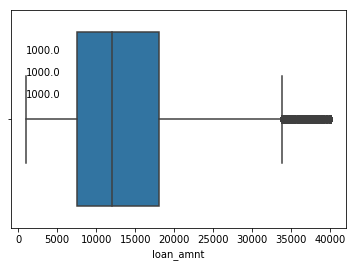

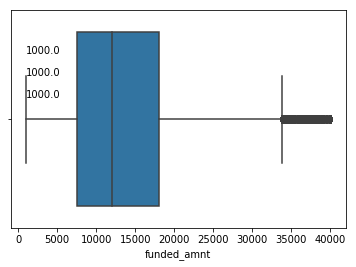

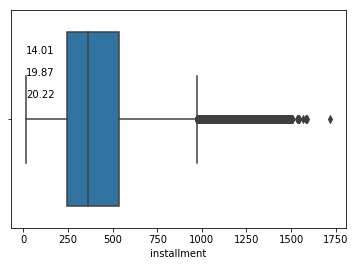

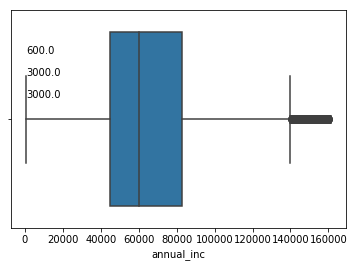

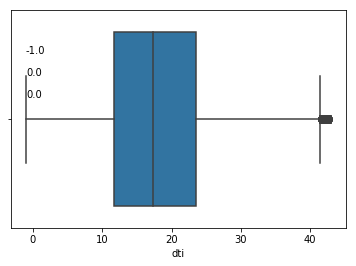

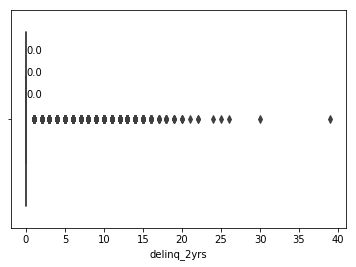

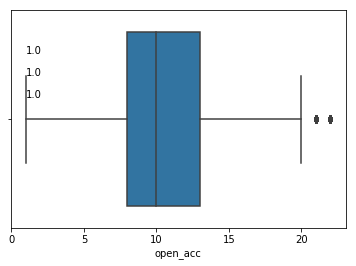

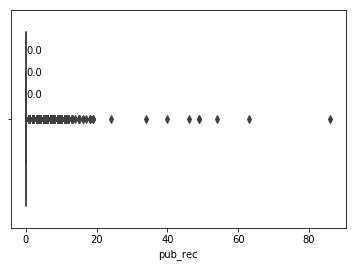

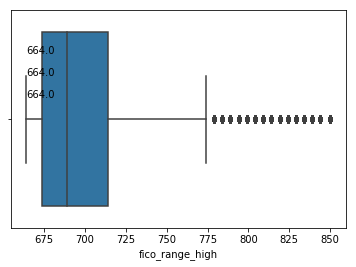

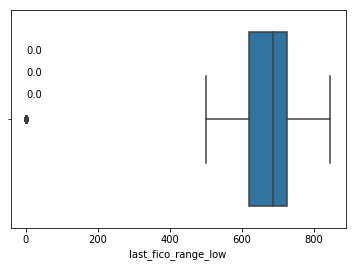

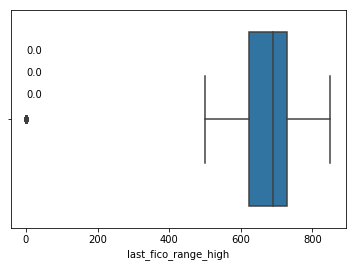

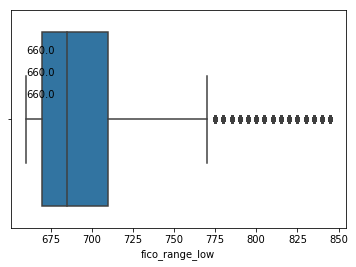

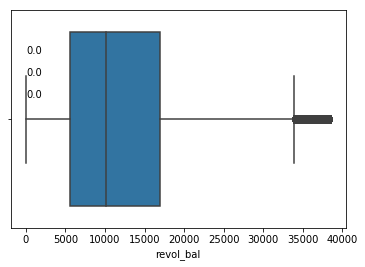

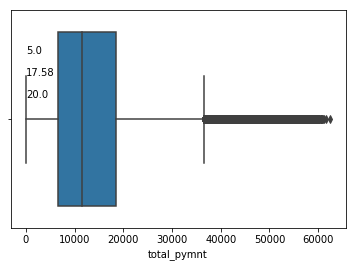

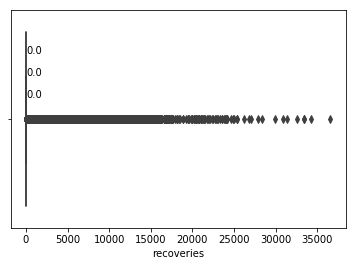

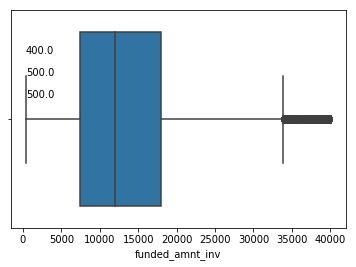

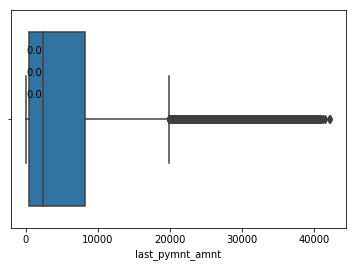

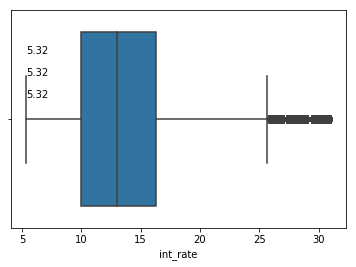

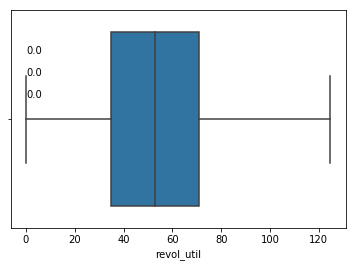

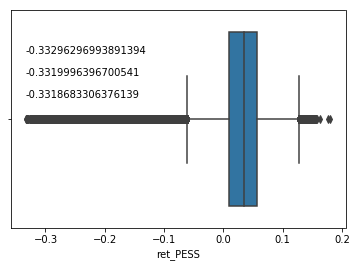

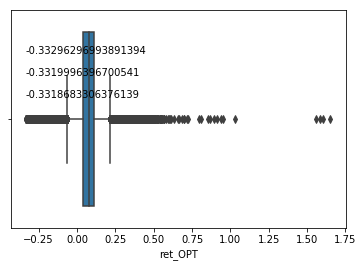

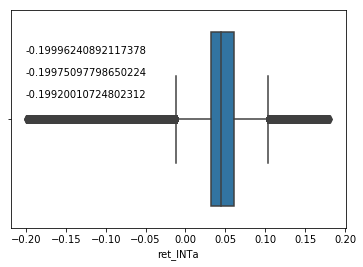

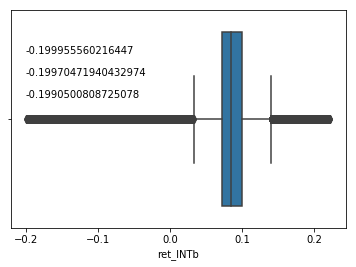

term
number of unique values: 2
 36 months    612268
 60 months    186917
Name: term, dtype: int64


grade
number of unique values: 7
B    233036
C    226073
A    127761
D    124666
E     60451
F     21625
G      5573
Name: grade, dtype: int64


emp_length
number of unique values: 12
10+ years    253206
2 years       72997
3 years       64467
< 1 year      63304
1 year        52832
5 years       51490
4 years       48374
6 years       39633
7 years       38286
8 years       38180
9 years       31234
Name: emp_length, dtype: int64


zip_code
number of unique values: 928
945xx    8933
112xx    8365
750xx    8344
606xx    7292
331xx    6822
300xx    6737
900xx    6565
891xx    6530
070xx    6153
770xx    6070
100xx    5970
917xx    5964
330xx    5937
104xx    5804
921xx    5216
852xx    5125
117xx    4995
925xx    4892
913xx    4598
926xx    4525
113xx    4305
334xx    4299
956xx    4287
853xx    4232
481xx    4166
021xx    4014
928xx    3961
920xx    3892
802xx    3884
604xx    3883
    

MORTGAGE    379932
RENT        337780
OWN          81287
ANY            105
OTHER           43
NONE            38
Name: home_ownership, dtype: int64


application_type
number of unique values: 2
Individual    794765
Joint App       4420
Name: application_type, dtype: int64


loan_status
number of unique values: 3
Fully Paid     632261
Charged Off    166590
Default           334
Name: loan_status, dtype: int64


purpose
number of unique values: 14
debt_consolidation    476094
credit_card           169987
home_improvement       48178
other                  43810
major_purchase         17087
small_business          9029
car                     8854
medical                 8677
moving                  5759
vacation                5291
house                   3801
wedding                 1951
renewable_energy         587
educational               80
Name: purpose, dtype: int64


verification_status
number of unique values: 3
Source Verified    292393
Not Verified       253397
Verified      

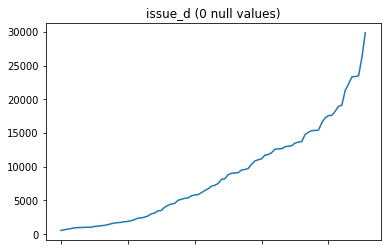

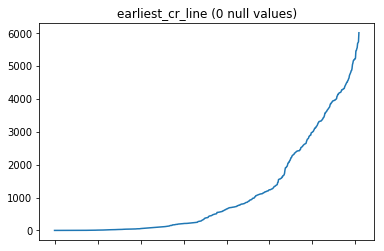

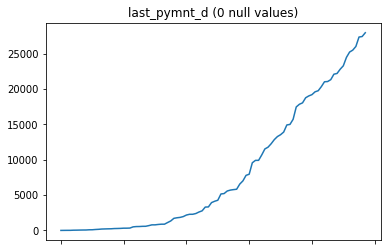

In [46]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

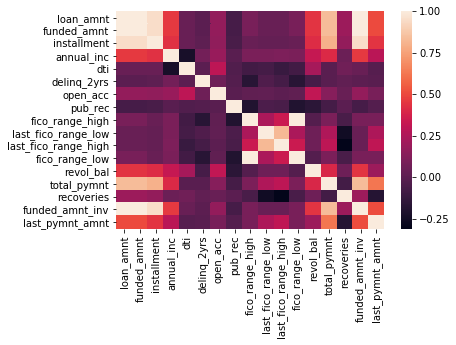

In [47]:
import seaborn as sns 
#sns.pairplot(final_data[float_cols]);
correlation = final_data[float_cols].corr()
sns.heatmap(correlation)

In [48]:
float_cols[8],float_cols[9],float_cols[1],float_cols[2]

('fico_range_high', 'last_fico_range_low', 'funded_amnt', 'installment')

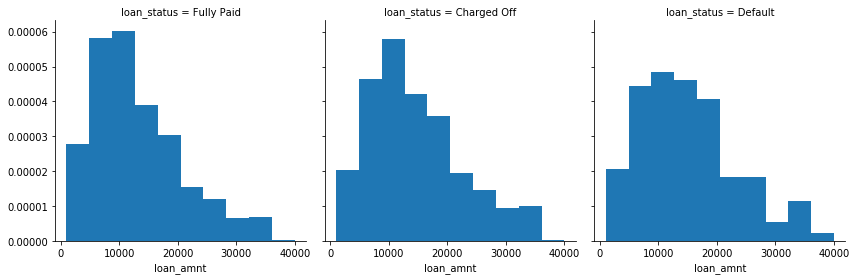

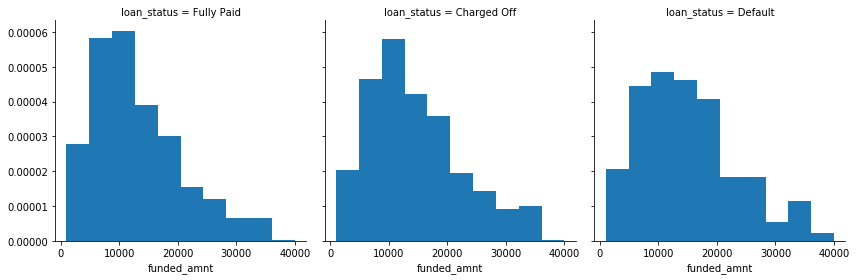

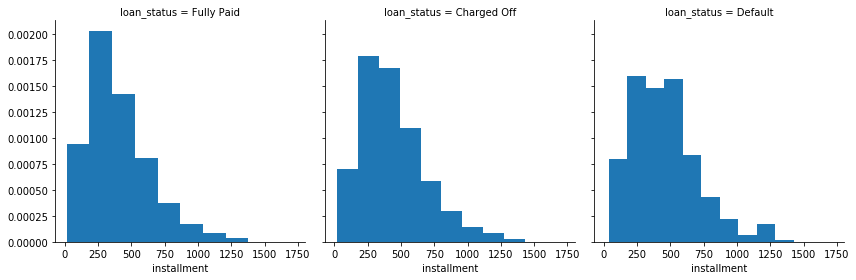

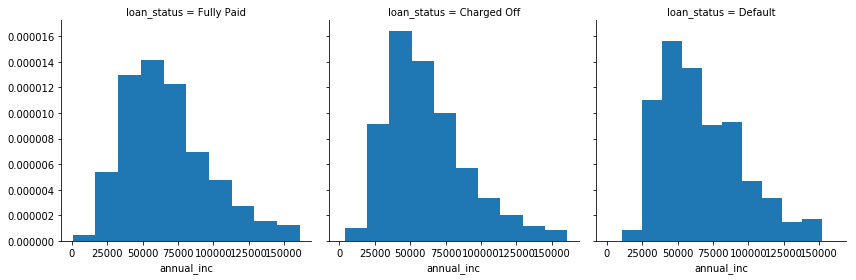

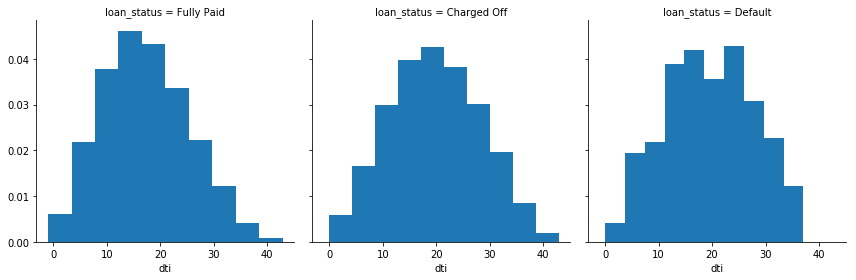

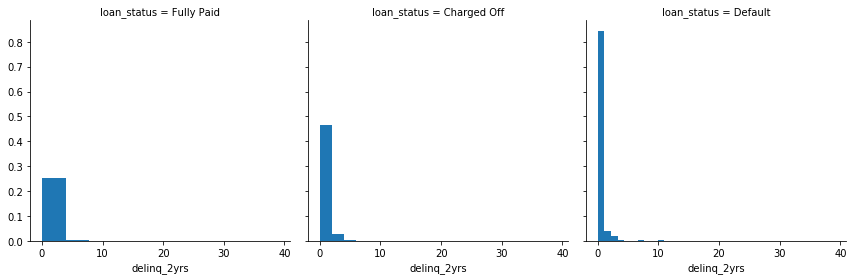

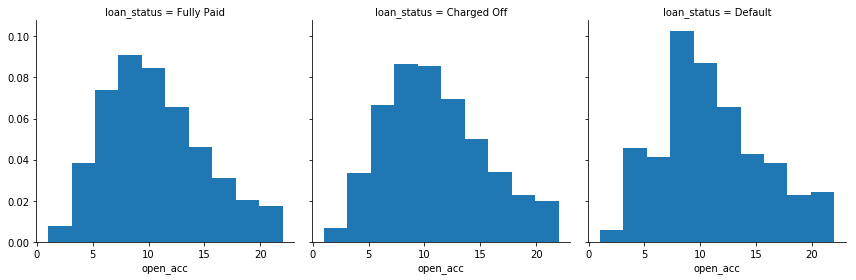

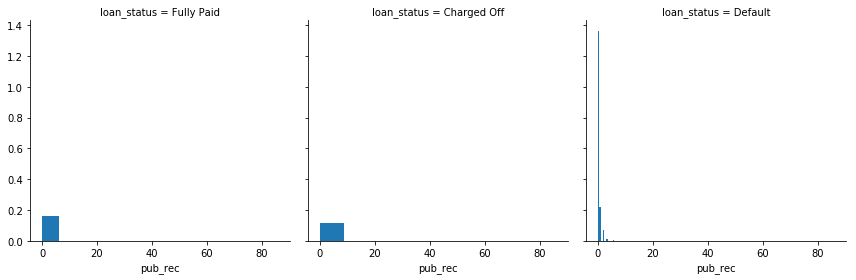

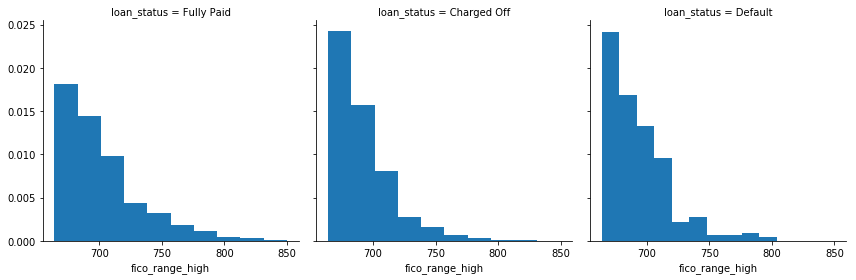

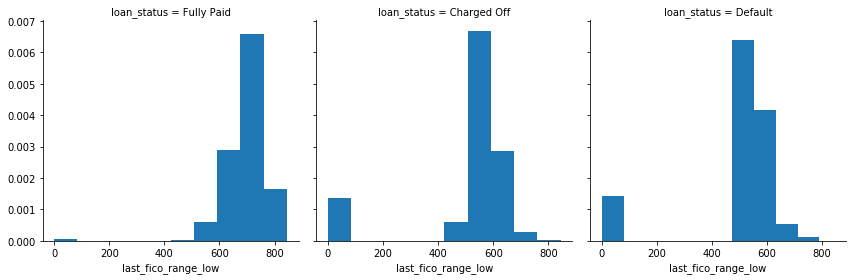

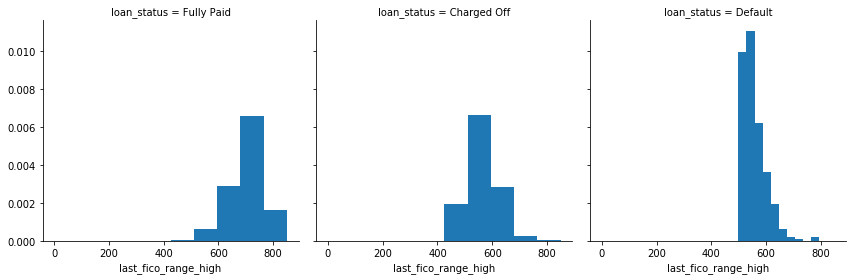

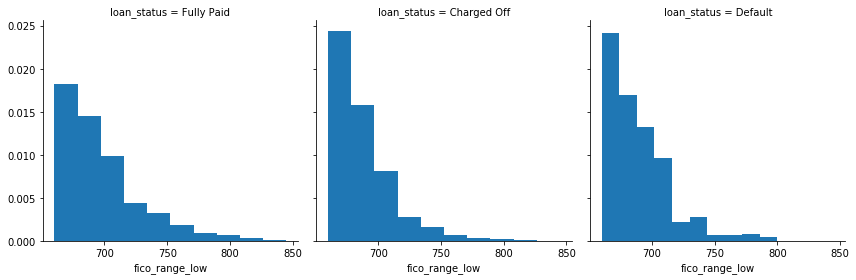

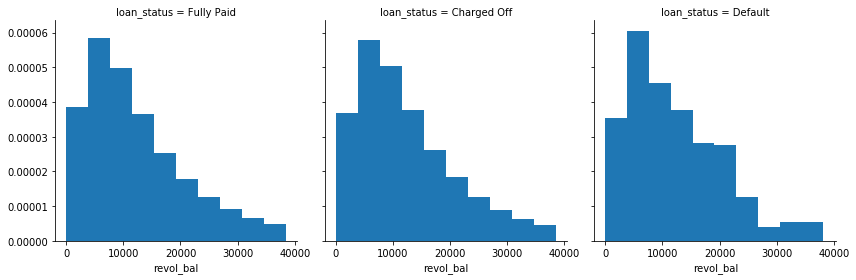

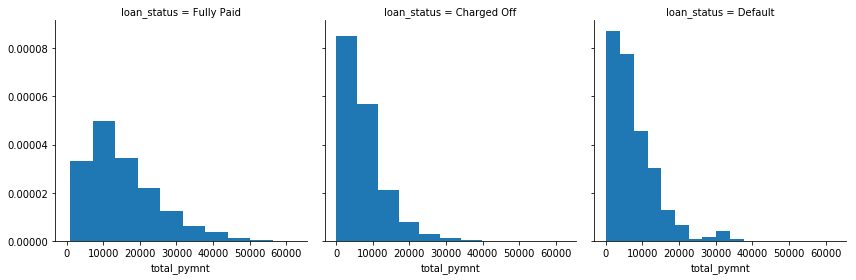

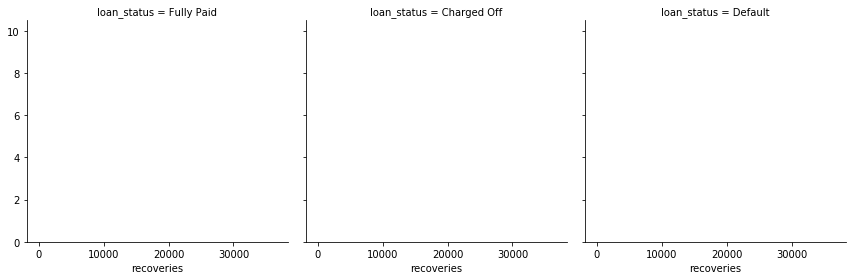

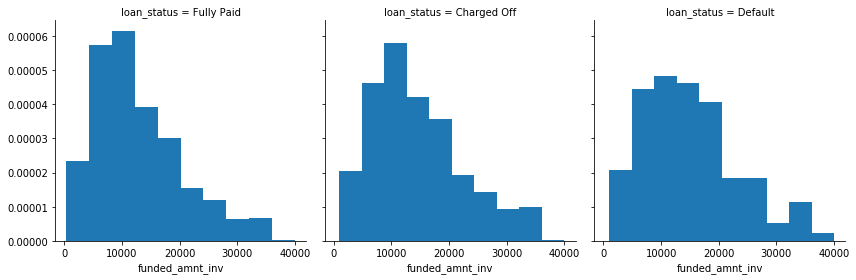

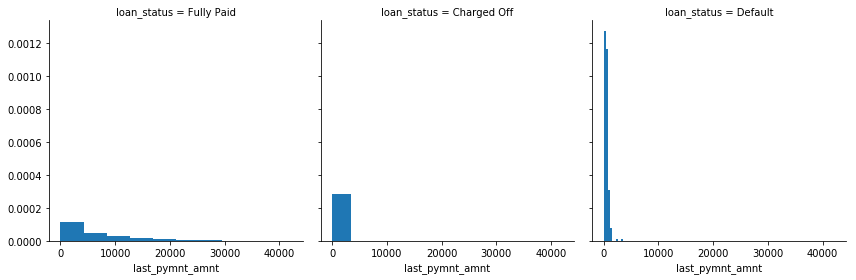

In [49]:
for i in float_cols:
    g = sns.FacetGrid(final_data, col="loan_status", margin_titles=True, height=4)
    g.map(plt.hist, i, density=True)
    plt.show()

What do you observe after removing the outliers?

### Data Exploration
Solution to Q.7 from the handout

In [107]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : (x.ret_OPT).sum()/len(x) ) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : (x.ret_PESS).sum()/len(x) ) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : (x.ret_INTa).sum()/len(x) ) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : (x.ret_INTb).sum()/len(x) )  # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : (x.int_rate).sum()/len(x) ) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,16.051203,6.428262,7.247279,0.037997,0.016980,0.031617,0.067804
B,29.163501,13.617499,10.884537,0.048801,0.016290,0.031431,0.067731
C,28.269478,22.757552,14.079600,0.051822,0.006510,0.024858,0.060467
D,15.585323,30.888643,17.516971,0.054077,0.000787,0.019776,0.054473
E,7.541722,39.635250,20.692435,0.055477,-0.009402,0.010749,0.044079
F,2.693986,45.802230,24.423366,0.060601,-0.014374,0.005265,0.037756
G,0.694786,50.419868,27.060725,0.058822,-0.028918,-0.007246,0.024075


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [108]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = set(continuous_features) - set(["total_pymnt","recoveries"])

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

In [109]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )

In [110]:
set(final_data.issue_d)

{datetime.date(2007, 6, 1),
 datetime.date(2007, 7, 1),
 datetime.date(2007, 8, 1),
 datetime.date(2007, 9, 1),
 datetime.date(2007, 10, 1),
 datetime.date(2007, 11, 1),
 datetime.date(2007, 12, 1),
 datetime.date(2008, 1, 1),
 datetime.date(2008, 2, 1),
 datetime.date(2008, 3, 1),
 datetime.date(2008, 4, 1),
 datetime.date(2008, 5, 1),
 datetime.date(2008, 6, 1),
 datetime.date(2008, 7, 1),
 datetime.date(2008, 8, 1),
 datetime.date(2008, 9, 1),
 datetime.date(2008, 10, 1),
 datetime.date(2008, 11, 1),
 datetime.date(2008, 12, 1),
 datetime.date(2009, 1, 1),
 datetime.date(2009, 2, 1),
 datetime.date(2009, 3, 1),
 datetime.date(2009, 4, 1),
 datetime.date(2009, 5, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 7, 1),
 datetime.date(2009, 8, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2009, 10, 1),
 datetime.date(2009, 11, 1),
 datetime.date(2009, 12, 1),
 datetime.date(2010, 1, 1),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 3, 1),
 datetime.date(2010, 4, 1),
 datetime.d